# ICS 485 Project Part-B
### Strategies: Least Confidence, Entropy

In [ ]:
%pip install matplotlib

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt


## 0 - Configuration

In [5]:
TRAIN_PATH = "dataset-train-vf.csv"
TEST_PATH  = "dataset-test-vf.csv"

RANDOM_STATE = 42

# Instructor requirements
N_INIT_LABELED = 50                          # start with 50 random labeled
BATCH_SIZE = 30                              # choose between 20 and 50 (50 - 20)
MAX_ITERS = 50                               # safety cap, loop stops earlier if pool ends
EVAL_TEST_SIZE = 0.20                        # hold-out labeled evaluation set (for reporting learning curve)

# Feature choices
DROP_ID = True
DROP_F10 = True                              # you can set False to keep f10, but it has heavy missingness

# Logistic Regression options
USE_CLASS_WEIGHT_BALANCED = True             # strongly recommended for your imbalance
C_VALUE = 10.0                               # you can tune this, start with 1.0 or 10.0
SOLVER = "liblinear"                         # robust for small/medium and binary. 'saga' is also fine

# Threshold policy
USE_THRESHOLD_TUNING = False                 # keep False to avoid extra complexity
THRESH_GRID = np.linspace(0.05, 0.95, 19)    # used only if threshold tuning True

# Stop early if close to "full-label" logistic baseline
EARLY_STOP = True
TARGET_GAP = 0.02                            # stop when active learning reaches (baseline - gap)


## 1 - Load Data

In [6]:
df = pd.read_csv(TRAIN_PATH)

# Split X, y
y_all = df["y"].astype(str)
X_all = df.drop(columns=["y"]).copy()

if DROP_ID and "ID" in X_all.columns:
    X_all = X_all.drop(columns=["ID"])

if DROP_F10 and "f10" in X_all.columns:
    X_all = X_all.drop(columns=["f10"])

# Identify numeric and categorical columns
cat_cols = ["f11"] if "f11" in X_all.columns else []
num_cols = [c for c in X_all.columns if c not in cat_cols]

print("X shape:", X_all.shape)
print("Label distribution:\n", y_all.value_counts())


X shape: (4480, 10)
Label distribution:
 y
square    4181
circle     299
Name: count, dtype: int64


## 2 - Preprocess & Model Pipeline

In [7]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

lr = LogisticRegression(
    C=C_VALUE,
    solver=SOLVER,
    max_iter=2000,
    class_weight=("balanced" if USE_CLASS_WEIGHT_BALANCED else None),
    random_state=RANDOM_STATE
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lr)
])


## 3 - Hold-out Evaluation Set

This eval set is only for plotting and reporting learning curves. The active learning pool is "unlabeled" except for the oracle y values we reveal when queried.

In [8]:
X_pool, X_eval, y_pool, y_eval = train_test_split(
    X_all, y_all,
    test_size=EVAL_TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_all
)

X_pool = X_pool.reset_index(drop=True)
y_pool = y_pool.reset_index(drop=True)
X_eval = X_eval.reset_index(drop=True)
y_eval = y_eval.reset_index(drop=True)

print("\nPool size:", len(X_pool), "Eval size:", len(X_eval))
print("Eval label distribution:\n", y_eval.value_counts())



Pool size: 3584 Eval size: 896
Eval label distribution:
 y
square    836
circle     60
Name: count, dtype: int64


## 4 - Baseline: Full-label logistic regression

In [9]:
pipe.fit(X_pool, y_pool)
p_eval = pipe.predict_proba(X_eval)
classes = list(pipe.named_steps["model"].classes_)
circle_idx = classes.index("circle")

pred_eval = np.where(p_eval[:, circle_idx] >= 0.5, "circle", "square")
baseline_f1 = f1_score(y_eval, pred_eval, pos_label="circle")

print("\nFull-label logistic baseline F1(circle) on eval:", round(baseline_f1, 4))


Full-label logistic baseline F1(circle) on eval: 0.3402


## 5 - Query Strategies

In [10]:
def score_least_confidence(proba_2col: np.ndarray) -> np.ndarray:
    # uncertainty = 1 - max_k p(y=k|x)
    return 1.0 - np.max(proba_2col, axis=1)

def score_entropy(proba_2col: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    # entropy = - sum_k p_k log p_k
    p = np.clip(proba_2col, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def tune_threshold_on_labeled(pipe_fitted, X_l, y_l, X_e, y_e, circle_idx, grid):
    # OPTIONAL. This tunes threshold using eval set, which is not ideal if you want pure reporting.
    # So keep USE_THRESHOLD_TUNING=False unless you have a separate validation set.
    best_t, best_f1 = 0.5, -1.0
    proba = pipe_fitted.predict_proba(X_e)[:, circle_idx]
    for t in grid:
        pred = np.where(proba >= t, "circle", "square")
        f1 = f1_score(y_e, pred, pos_label="circle")
        if f1 > best_f1:
            best_f1 = f1
            best_t = float(t)
    return best_t, float(best_f1)


## 6 - Active Learning Loop

In [11]:
def run_active_learning(strategy_name: str, batch_size: int):
    rng = np.random.RandomState(RANDOM_STATE)

    n_pool = len(X_pool)
    all_indices = np.arange(n_pool)

    # Start with 50 random labeled indices (as required)
    labeled_idx = rng.choice(all_indices, size=min(N_INIT_LABELED, n_pool), replace=False)
    labeled_idx = np.array(sorted(labeled_idx))

    unlabeled_mask = np.ones(n_pool, dtype=bool)
    unlabeled_mask[labeled_idx] = False

    history = []
    it = 0

    while it < MAX_ITERS:
        it += 1

        unlabeled_idx = all_indices[unlabeled_mask]
        if len(unlabeled_idx) == 0:
            break

        # Train on currently labeled set
        X_l = X_pool.iloc[labeled_idx]
        y_l = y_pool.iloc[labeled_idx]

        pipe.fit(X_l, y_l)

        # Evaluate on hold-out eval set
        proba_eval = pipe.predict_proba(X_eval)
        classes = list(pipe.named_steps["model"].classes_)
        circle_idx = classes.index("circle")

        if USE_THRESHOLD_TUNING:
            t_used, f1_eval = tune_threshold_on_labeled(pipe, X_l, y_l, X_eval, y_eval, circle_idx, THRESH_GRID)
            pred_eval = np.where(proba_eval[:, circle_idx] >= t_used, "circle", "square")
        else:
            t_used = 0.5
            pred_eval = np.where(proba_eval[:, circle_idx] >= 0.5, "circle", "square")
            f1_eval = f1_score(y_eval, pred_eval, pos_label="circle")

        # Save stats
        history.append({
            "iter": it,
            "labeled": int(len(labeled_idx)),
            "unlabeled_left": int(len(unlabeled_idx)),
            "threshold": float(t_used),
            "f1_circle_eval": float(f1_eval),
        })

        print(f"[{strategy_name}] iter={it:02d} labeled={len(labeled_idx):4d} "
              f"unlabeled_left={len(unlabeled_idx):4d} F1(circle)={f1_eval:.4f} t={t_used:.2f}")

        # Early stop if close to baseline
        if EARLY_STOP and (f1_eval >= baseline_f1 - TARGET_GAP):
            print(f"[{strategy_name}] Early stop. Reached baseline gap target.")
            break

        # Score unlabeled pool using chosen strategy
        X_u = X_pool.iloc[unlabeled_idx]
        proba_u = pipe.predict_proba(X_u)

        if strategy_name.lower().startswith("least"):
            scores = score_least_confidence(proba_u)
        elif strategy_name.lower().startswith("entropy"):
            scores = score_entropy(proba_u)
        else:
            raise ValueError("Unknown strategy_name. Use 'least_confidence' or 'entropy'.")

        # Query top-k most uncertain
        k = min(batch_size, len(unlabeled_idx))
        topk_pos = np.argsort(scores)[-k:]     # highest uncertainty
        queried_idx = unlabeled_idx[topk_pos]

        # Add to labeled set, remove from unlabeled pool
        labeled_idx = np.unique(np.concatenate([labeled_idx, queried_idx]))
        unlabeled_mask[queried_idx] = False

    hist_df = pd.DataFrame(history)
    return hist_df


# Run both strategies
hist_lc = run_active_learning("least_confidence", BATCH_SIZE)
hist_ent = run_active_learning("entropy", BATCH_SIZE)

[least_confidence] iter=01 labeled=  50 unlabeled_left=3534 F1(circle)=0.2802 t=0.50
[least_confidence] iter=02 labeled=  80 unlabeled_left=3504 F1(circle)=0.2532 t=0.50
[least_confidence] iter=03 labeled= 110 unlabeled_left=3474 F1(circle)=0.2821 t=0.50
[least_confidence] iter=04 labeled= 140 unlabeled_left=3444 F1(circle)=0.3373 t=0.50
[least_confidence] Early stop. Reached baseline gap target.
[entropy] iter=01 labeled=  50 unlabeled_left=3534 F1(circle)=0.2802 t=0.50
[entropy] iter=02 labeled=  80 unlabeled_left=3504 F1(circle)=0.2532 t=0.50
[entropy] iter=03 labeled= 110 unlabeled_left=3474 F1(circle)=0.2821 t=0.50
[entropy] iter=04 labeled= 140 unlabeled_left=3444 F1(circle)=0.3373 t=0.50
[entropy] Early stop. Reached baseline gap target.


## Plots & Final Report

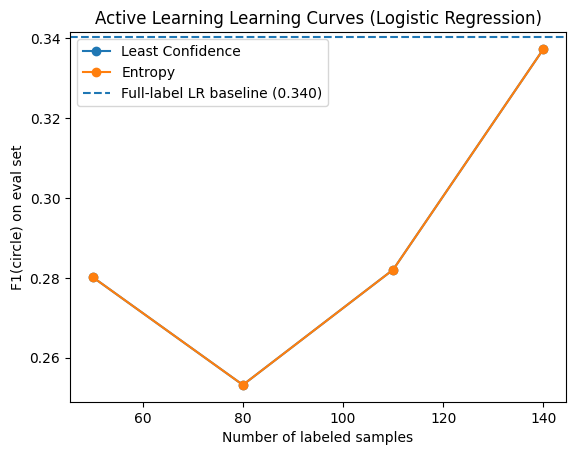


=== FINAL ITERATION SUMMARY ===
Least Confidence final: {'iter': 4.0, 'labeled': 140.0, 'unlabeled_left': 3444.0, 'threshold': 0.5, 'f1_circle_eval': 0.3373493975903614}
Entropy final: {'iter': 4.0, 'labeled': 140.0, 'unlabeled_left': 3444.0, 'threshold': 0.5, 'f1_circle_eval': 0.3373493975903614}

=== Final classification report for best strategy (last iteration) ===
Best strategy: least_confidence
Final labeled size: 140
              precision    recall  f1-score   support

      circle     0.2642    0.4667    0.3373        60
      square     0.9595    0.9067    0.9323       836

    accuracy                         0.8772       896
   macro avg     0.6118    0.6867    0.6348       896
weighted avg     0.9129    0.8772    0.8925       896

Confusion matrix (circle, square):
[[ 28  32]
 [ 78 758]]


In [12]:
plt.figure()
plt.plot(hist_lc["labeled"], hist_lc["f1_circle_eval"], marker="o", label="Least Confidence")
plt.plot(hist_ent["labeled"], hist_ent["f1_circle_eval"], marker="o", label="Entropy")
plt.axhline(baseline_f1, linestyle="--", label=f"Full-label LR baseline ({baseline_f1:.3f})")
plt.xlabel("Number of labeled samples")
plt.ylabel("F1(circle) on eval set")
plt.title("Active Learning Learning Curves (Logistic Regression)")
plt.legend()
plt.show()

print("\n=== FINAL ITERATION SUMMARY ===")
if len(hist_lc) > 0:
    print("Least Confidence final:", hist_lc.iloc[-1].to_dict())
if len(hist_ent) > 0:
    print("Entropy final:", hist_ent.iloc[-1].to_dict())

print("\n=== Final classification report for best strategy (last iteration) ===")
# Pick the better of the two (last F1)
f1_lc_last = hist_lc["f1_circle_eval"].iloc[-1] if len(hist_lc) else -1
f1_ent_last = hist_ent["f1_circle_eval"].iloc[-1] if len(hist_ent) else -1

best_name = "least_confidence" if f1_lc_last >= f1_ent_last else "entropy"
print("Best strategy:", best_name)

# Refit the model on the final labeled set for the best strategy
# Re-run that strategy quickly to reconstruct final labeled set
# (Simple approach: run again but store labeled indices inside the function if you want to be cleaner)
# Here we re-run and then fit using its last labeled size, which is enough for reporting.
best_hist = hist_lc if best_name == "least_confidence" else hist_ent
best_labeled_count = int(best_hist["labeled"].iloc[-1])

# Recreate final labeled set (random start, same seed, same path) and stop once we hit labeled_count
def get_final_labeled_indices(strategy_name: str, target_labeled: int):
    rng = np.random.RandomState(RANDOM_STATE)
    n_pool = len(X_pool)
    all_indices = np.arange(n_pool)

    labeled_idx = rng.choice(all_indices, size=min(N_INIT_LABELED, n_pool), replace=False)
    labeled_idx = np.array(sorted(labeled_idx))

    unlabeled_mask = np.ones(n_pool, dtype=bool)
    unlabeled_mask[labeled_idx] = False

    while len(labeled_idx) < target_labeled:
        unlabeled_idx = all_indices[unlabeled_mask]
        if len(unlabeled_idx) == 0:
            break

        X_l = X_pool.iloc[labeled_idx]
        y_l = y_pool.iloc[labeled_idx]
        pipe.fit(X_l, y_l)

        X_u = X_pool.iloc[unlabeled_idx]
        proba_u = pipe.predict_proba(X_u)

        if strategy_name.lower().startswith("least"):
            scores = score_least_confidence(proba_u)
        else:
            scores = score_entropy(proba_u)

        k = min(BATCH_SIZE, len(unlabeled_idx), target_labeled - len(labeled_idx))
        topk_pos = np.argsort(scores)[-k:]
        queried_idx = unlabeled_idx[topk_pos]

        labeled_idx = np.unique(np.concatenate([labeled_idx, queried_idx]))
        unlabeled_mask[queried_idx] = False

    return labeled_idx

final_labeled_idx = get_final_labeled_indices(best_name, best_labeled_count)

X_final = X_pool.iloc[final_labeled_idx]
y_final = y_pool.iloc[final_labeled_idx]

pipe.fit(X_final, y_final)
proba_eval = pipe.predict_proba(X_eval)
classes = list(pipe.named_steps["model"].classes_)
circle_idx = classes.index("circle")
pred_eval = np.where(proba_eval[:, circle_idx] >= 0.5, "circle", "square")

print("Final labeled size:", len(final_labeled_idx))
print(classification_report(y_eval, pred_eval, digits=4))
print("Confusion matrix (circle, square):")
print(confusion_matrix(y_eval, pred_eval, labels=["circle", "square"]))
